<a href="https://colab.research.google.com/github/z-a-f/ManningCV/blob/master/Manning_CV_LiveProject_MS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

## SVHN Datasets

In [0]:
import os
# get the SVHN data
files = [
  'train_32x32.mat',
  'test_32x32.mat'
]
for file_name in files:
  if not os.path.isfile(file_name):
    !wget http://ufldl.stanford.edu/housenumbers/{file_name}
  else:
    print(f'{file_name} already exists, skipping download...')

train_32x32.mat already exists, skipping download...
test_32x32.mat already exists, skipping download...


In [0]:
import numpy as np
from scipy.io import loadmat

def flip_data_axis(dataset, axes_to_flip):
  dataset['X'] = np.ascontiguousarray(dataset['X'].transpose(axes_to_flip))

def relabel(dataset, label_pair):
  old = label_pair[0]
  new = label_pair[1]
  old_labels_mask = (dataset['y'] == old)
  dataset['y'][old_labels_mask] = new

datasets = {}
for file_name in files:
  key_name = file_name.split('_')[0]
  datasets[key_name] = loadmat(file_name)
  # Change the data format from HWCN to NHWC
  flip_data_axis(datasets[key_name], (-1, 0, 1, 2))
  # Relabel some of the targets
  relabel(datasets[key_name], (10, 0))


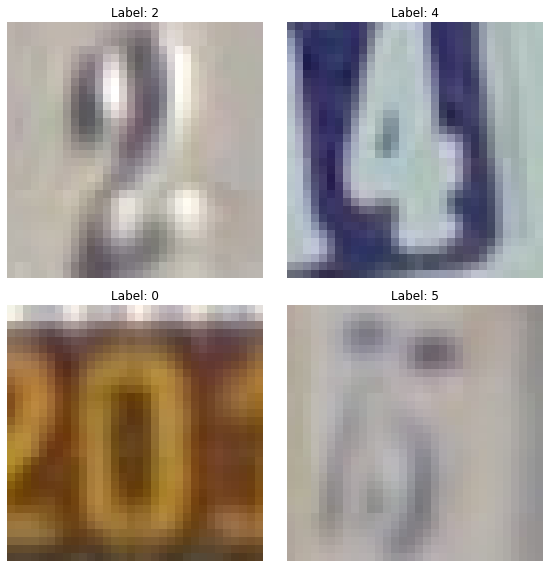

In [0]:
from collections.abc import Iterable
import matplotlib as mpl
import matplotlib.pyplot as plt

def show_image(X, y=None, ax=None):
  if ax is None:
    ax = plt.gca()
  im_handle = ax.imshow(X)
  if y is not None:
    while isinstance(y, Iterable) and len(y) == 1:
      y = y[0]
    ax.set_title(f'Label: {y}')
  ax.grid(False)
  ax.axis('off')
  return im_handle

def show_random_example(dataset, ax=None):
  idx = np.random.randint(0, len(dataset['X']))
  return show_image(dataset['X'][idx], dataset['y'][idx], ax)

fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
for a in ax.flat:
  show_random_example(datasets['train'], ax=a)
plt.tight_layout()

## COCO Dataset

In [0]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
  if not os.path.isfile(file_name):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name)
  if not os.path.isdir('.'.join(file_name.split('.')[:-1])):
    print("Unzipping", file_name)
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Unzipping annotations_trainval2017.zip
Finished unzipping annotations_trainval2017.zip
Done transferring all datasets


In [0]:
import json

annotation_files = [
  ('train', 'annotations/person_keypoints_train2017.json'),
  ('val', 'annotations/person_keypoints_val2017.json'),
]
annotations = {}

for file_name in annotation_files:
  key_name = file_name[0]
  with open(file_name[1], 'r') as f:
    annotations[key_name] = json.load(f)

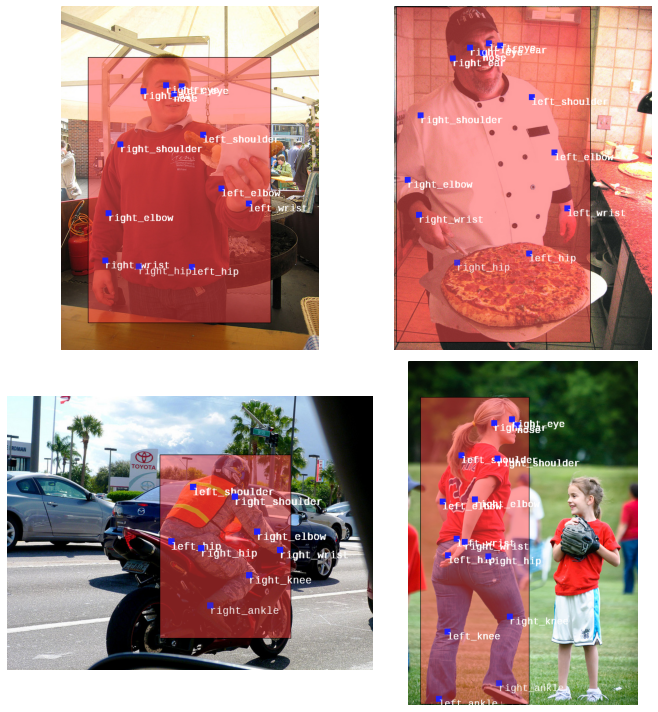

In [0]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

"""Shows an image and applies `process_fn` to it with `process_kwargs` keyword arguments"""
def show_image(image_dir, annotation, process_fn=None, process_kwargs=None, ax=None):
  file_name = f'{annotation["image_id"]:0>12d}.jpg'
  file_path = os.path.join(image_dir, file_name)

  if ax is None:
    ax = plt.gca()
  img = Image.open(file_path)
  if process_fn is not None:
    if process_kwargs is None:
      process_kwargs = {}
    img = process_fn(img, annotation, **process_kwargs)

  im_handle = ax.imshow(img)
  ax.axis('off')
  ax.grid(False)
  return im_handle

"""Shows the bounding box on an image image"""
def show_bbox(img, annotation, **kwargs):
  # img = img.convert('RGBA')
  bbox = annotation['bbox']
  bbox = bbox[:2] + [bbox[0] + bbox[2]] + [bbox[1] + bbox[3]]
  box_color = (255, 64, 64, 128)
  box_img = Image.new('RGBA', img.size, (255, 255, 255, 0))
  box_draw = ImageDraw.Draw(box_img)
  box_draw.rectangle(bbox, fill=box_color, outline=(0, 0, 0, 255))
  del box_draw
  return Image.alpha_composite(img, box_img)

"""Shows a keypoint on an image"""
def show_keypoint(img, point, label=None, point_draw=None):
  # img = img.convert('RGBA')
  point_size = (5, 5)
  point_color = (32, 32, 255, 200)
  point_rectangle = (point[0]-point_size[0], point[1]-point_size[1], point[0]+point_size[0], point[1]+point_size[1])
  if point_draw is None:
    point_img = Image.new('RGBA', img.size, (255, 255, 255, 0))
    point_draw = ImageDraw.Draw(point_img)
  else:
    point_draw, point_img = point_draw
  point_draw.rectangle(point_rectangle, fill=point_color, outline=point_color)
  point_draw.point(point, fill=(255, 255, 255, 128))
  if label is not None:
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', size=18, encoding='unic')
    point_draw.text(tuple(point), label, fill=(255, 255, 255, 255), font=font)
  return (point_draw, point_img), Image.alpha_composite(img, point_img)

"""Shows keypoints on an image"""
def show_keypoints(img, annotation, keypoint_names=None, **kwargs):
  keypoints = np.array(annotation['keypoints']).reshape(-1, 3)
  # print(keypoints)
  point_draw = None
  for idx, keypoint in enumerate(keypoints):
    if keypoint[-1] == 0:
      continue
    location = keypoint[:2]
    label_name = keypoint_names[idx] if keypoint_names is not None else None
    point_draw, img = show_keypoint(img, location, label_name, point_draw=point_draw)
  return img

"""Runs a list of functions on an image.
The functions must have a signature of (img, annotation, **kwargs)"""
def transform(*function_list):
  def _t(img, annotation, **kwargs):
    for f in function_list:
      img = f(img, annotation, **kwargs)
    return img
  return _t

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
idx_list = [136187, 109963, 0, 42102]
for idx, a in enumerate(ax.flat):
  idx = idx_list[idx]
  show_image('train2017',
            annotations['train']['annotations'][idx],
            process_fn=transform(lambda img, anno, **kwargs: img.convert('RGBA'),
                                  show_bbox,
                                  show_keypoints),
            process_kwargs={'keypoint_names': annotations['train']['categories'][0]['keypoints']},
            ax=a)
plt.tight_layout()
